# Họ tên: Nguyễn Hoàng Linh
# MSSV: 1712559

### Phân tích dữ liệu khách hàng sử dụng dịch vụ thanh toán trực tuyến tại các cửa hàng nước uống trong phân khúc Beverage

# Import

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(rc={'figure.figsize':(10,4)})

# Khám phá dữ liệu

Dữ liệu đã được tiền xử lý và được tóm tắt như sau đây:
+ Thay thể dữ liệu Null, Outliers và xoá dữ liệu trùng lắp
+ Dữ liệu bị lỗi với merchant_name (không độc lập với service_id) nên giải pháp là tạo thêm cột Group_store để riêng biệt cho tên cửa hàng, một số merchant_name bị lỗi ví dụ như Gongcha Hai Bà Trưng, Gongcha Nguyễn Văn Cừ,... được đổi trong Group_store là Gongcha
+ Kết nối dữ liệu transaction và merchant, bằng cách sử dụng join dựa trên service_id và store_id của merchant, do đó, dữ liệu transaction sẽ được thêm vào 2 cột là store_name và Group_store

### Đọc dữ liệu

In [2]:
beverage = pd.read_csv("data/beverage_data.csv",encoding = "utf-8")
beverage.head()

,service_id,store_id,service_group,merchant_name,merchant_address,store_name,store_address,store_longitude,store_latitude,Group_store,Area
0,3856987200481659347,5344902699306350073,beverage,3T COFFEE,"355 Hoàng Sa, Phường Tân Định, Quận 1, Thành P...",3T COFFEE QUẬN 1,"355 Hoàng Sa, Phường Tân Định, Quận 1, Thành P...",106.686097,10.793981,3T COFFEE,South
1,7508698289722542420,456616057538839028,beverage,ALTO COFFEE,"408 điện biên phủ, Phường 11, Quận 10, Thành P...",ALTO COFFEE,"408 điện biên phủ, Phường 11, Quận 10, Thành P...",106.681364,10.775119,ALTO COFFEE,South
2,1541760682999376676,4712493303835130520,beverage,Apsara Cafe,"Số 1 Phạm Ngũ Lão, Phường Phan Chu Trinh, Quậ...",Apsara Café,"Số 1 Phạm Ngũ Lão, Phường Phan Chu Trinh, Quậ...",105.859190,21.024398,Apsara Cafe,North
3,6835189764919746072,2442775523715724880,beverage,B59 COFFEE,"370 Thái Hà, Phường Láng Hạ, Quận Đống Đa, ...",B59 COFFEE,"59 Khương Trung, Phường Khương Đình, Quận Tha...",105.815958,20.993166,B59 COFFEE,North
4,6835189764919746072,6028938650525639113,beverage,B59 COFFEE,"370 Thái Hà, Phường Láng Hạ, Quận Đống Đa, ...",B59 COFFEE,"370 Thái Hà, Phường Trung Liệt, Quận Đống Đa...",105.816878,21.015263,B59 COFFEE,North


In [5]:
transaction_beverage = pd.read_csv("data/transaction_beverage_data.csv",encoding = "utf-8")
transaction_beverage.head()

,timestamp,user_id,service_id,store_id,amount,store_name,Group_store
0,2019-08-03 13:25:41.199,2026549242216771,3856987200481659347,5344902699306350073,45000,3T COFFEE QUẬN 1,3T COFFEE
1,2019-08-10 12:13:41.106,108673406767381178,3856987200481659347,5344902699306350073,427000,3T COFFEE QUẬN 1,3T COFFEE
2,2019-08-10 03:02:43.395,122568279175305296,3856987200481659347,5344902699306350073,1464000,3T COFFEE QUẬN 1,3T COFFEE
3,2019-08-02 08:02:08.446,123040230497275047,3856987200481659347,5344902699306350073,188000,3T COFFEE QUẬN 1,3T COFFEE
4,2019-08-09 02:44:11.249,147121965879868116,3856987200481659347,5344902699306350073,51000,3T COFFEE QUẬN 1,3T COFFEE


### Kích thước của dữ liệu

In [6]:
num_rows,num_cols = beverage.shape
print(f'Dữ liệu beverage có {num_cols} cột')
print(f'Dữ liệu beverage có {num_rows} dòng')

Dữ liệu beverage có 11 cột
Dữ liệu beverage có 551 dòng


In [7]:
num_rows,num_cols = transaction_beverage.shape
print(f'Dữ liệu transaction có {num_cols} cột')
print(f'Dữ liệu transaction có {num_rows} dòng')

Dữ liệu transaction có 7 cột
Dữ liệu transaction có 91282 dòng


### Mỗi dòng có ý nghĩa gì?

+ Mỗi dòng của dữ liệu merchant ứng với thông tin của các cửa hàng trên Việt Nam có sử dụng ví điện tử thanh toán
+ Mỗi dòng của dữ liệu transaction ứng với thông tin của khách hàng mua tại cửa hàng theo thời gian với số tiền cụ thể
+ 2 dữ liệu được kết nối với nhau qua store_id và service_id

### Mỗi cột có ý nghĩa gì?

Beverage:
+ service_id: Mỗi service_id sẽ tương ứng với một loại cửa hàng nhất định
+ store_id  : Mỗi store_id tương ứng với 1 chi nhánh của cửa hàng
+ service_group: loại phục vụ (beverage, fnb)
+ merchant_name: Tên cửa hàng
+ merchant_address: Địa chỉ cửa hàng chính
+ store_name: Tên Chi nhánh
+ store_address: Địa chỉ chi nhánh
+ store_longitude, store_latitude: Kinh độ, Vĩ độ cửa hàng
+ Group_store: Tên cửa hàng
+ Area: Khu vực (South, Middle, North)

Transaction:
+ timestamp: Thời gian thanh toán
+ user_id, service_id, store_id : id của người dùng, dịch vụ, cửa hàng, được kết nối với dữ liệu beverage
+ amount: Lượng tiền giao dịch
+ store_name: Tên chi nhánh
+ Group_store: Tên cửa hàng

### Kiểu dữ liệu mỗi cột?

In [8]:
beverage.dtypes

service_id            int64
store_id              int64
service_group        object
merchant_name        object
merchant_address     object
store_name           object
store_address        object
store_longitude     float64
store_latitude      float64
Group_store          object
Area                 object
dtype: object

In [9]:
transaction_beverage.dtypes

timestamp      object
user_id         int64
service_id      int64
store_id        int64
amount          int64
store_name     object
Group_store    object
dtype: object

Nhận xét:
+ Cột timestamp có type là object nên sẽ chuyển về dạng datetime

In [11]:
transaction_beverage.timestamp = pd.to_datetime(transaction_beverage.timestamp)

### Miền giá trị của các cột dạng Numeric và Datetime

In [13]:
beverage.describe()

,service_id,store_id,store_longitude,store_latitude
count,5.510000e+02,5.510000e+02,551.000000,551.000000
mean,5.121517e+18,4.690778e+18,106.551840,13.152769
std,2.095906e+18,2.566419e+18,0.516023,4.233470
min,2.553443e+17,2.488144e+16,105.434852,10.015113
25%,3.615982e+18,2.509982e+18,106.624081,10.771480
50%,4.730843e+18,4.912359e+18,106.678497,10.796946
75%,7.261617e+18,6.715478e+18,106.700871,12.236758
max,9.181422e+18,9.185125e+18,109.197690,21.054535


In [12]:
transaction_beverage.describe()

,user_id,service_id,store_id,amount
count,9.128200e+04,9.128200e+04,9.128200e+04,9.128200e+04
mean,4.604032e+18,5.132343e+18,4.607915e+18,3.494421e+05
std,2.657028e+18,2.315344e+18,2.456306e+18,4.035323e+05
min,9.299966e+13,2.553443e+17,2.488144e+16,1.000000e+03
25%,2.303450e+18,3.615982e+18,2.616029e+18,8.500000e+04
50%,4.583576e+18,5.272998e+18,5.006294e+18,1.940000e+05
75%,6.903831e+18,7.217456e+18,6.323340e+18,4.380000e+05
max,9.223308e+18,9.181422e+18,9.175954e+18,2.000000e+06


In [15]:
print(transaction_beverage.timestamp.min(), transaction_beverage.timestamp.max())

2019-07-31 17:00:45.023000 2019-08-31 16:57:15.686000


## Đối với bài toán Recommendation, ta chú trọng đến những yếu tố sau: khoảng cách, thời điểm mua hàng, thói quen mua hàng của khách hàng. Nên có một số câu hỏi như sau:

+ Khách hàng thường đến cửa hàng là tại vì cửa hàng đó nổi tiếng (có nhiều chi nhánh) không?
+ Khách hàng thường đến cửa hàng mua nguyên nhân do các cửa hàng đó tập trung ở trung tâm thành phố không?
+ Khách hàng thường đến cửa hàng do thói quen theo thời gian hay không?
+ Khách hàng thường đến cửa hàng vào những thời điểm (ngày,tháng) nào nhiều nhất?

## Câu hỏi 1: Khách hàng thường đến cửa hàng là tại vì cửa hàng đó nổi tiếng (có nhiều chi nhánh) không?

### Để trả lời, ta xem số lượng giao dịch của 10 thương hiệu đứng đầu và 10 cửa hàng riêng lẻ đứng đầu

Để có được 10 cửa hiệu đứng đầu, ta sẽ thực hiện theo trình tự: Gom cụm nhóm Group_store của dữ liệu beverage, sau đó đếm số lượng của từng cửa hàng riêng biệt và sắp xếp theo chiều giảm dần, cuối cùng chỉ lấy 10 cửa hàng cao nhất

<IPython.core.display.Javascript object>


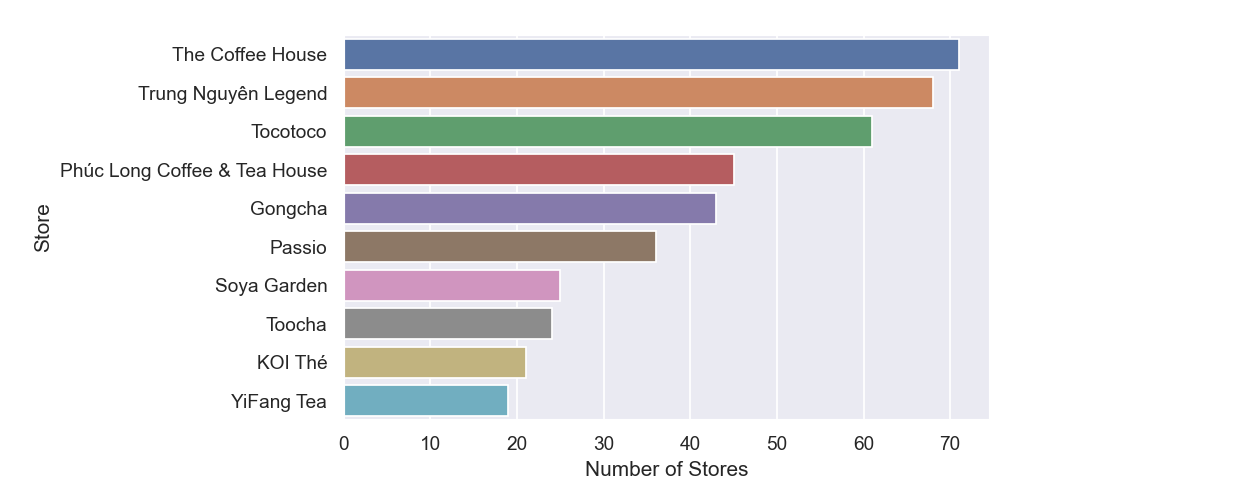

In [40]:
plotdata = beverage.groupby("Group_store").count().sort_values(by="service_id",ascending = False)[0:10]
ax = sns.barplot(y=plotdata.index,x="service_id",data = plotdata)
ax.set(xlabel='Number of Stores', ylabel='Store')
box = ax.get_position()
pos2 = [box.x0 + 0.15, box.y0 + 0.05, box.width / 1.5, box.height] 
ax.set_position(pos2)
top_10_store = plotdata.index.values

##### Qua đây, ta có thể nhận xét rằng cửa hàng The coffee House có nhiều chi nhánh nhất, theo sau đó là Trung Nguyên Legend, Tocotoco, phúc Long, Gongcha,...
##### Tất nhiên, ta cũng phải xem đến số lượng transaction trực tuyến diễn ra tại các cửa hàng

Để thực hiện được, ta sẽ lấy dữ liệu từ top 10 cửa hàng có nhiều chi nhánh nhất để tiếp tục. Đầu tiên, ta sẽ đếm số lượng transaction của mỗi Group_store và sắp xếp theo chiều giảm dần

In [42]:
plotdata = pd.DataFrame(columns = transaction_beverage.columns)
for i in range(len(top_10_store)):
    plotdata = plotdata.append(transaction_beverage[transaction_beverage.Group_store == top_10_store[i]],ignore_index = True)

<IPython.core.display.Javascript object>


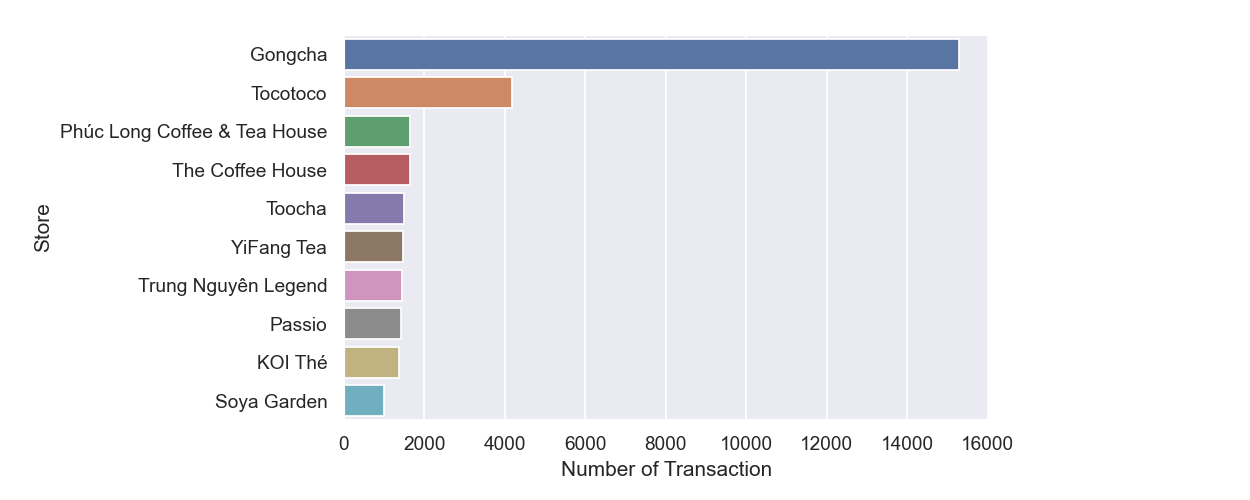

In [43]:
plotdata = plotdata.groupby(["Group_store"]).count().sort_values(by=["amount"],ascending = False)
ax = sns.barplot(y=plotdata.index,x="amount",data = plotdata)
ax.set(xlabel='Number of Transaction', ylabel='Store')
box = ax.get_position()
pos2 = [box.x0 + 0.15, box.y0 + 0.05, box.width / 1.5, box.height] 
ax.set_position(pos2)

<IPython.core.display.Javascript object>


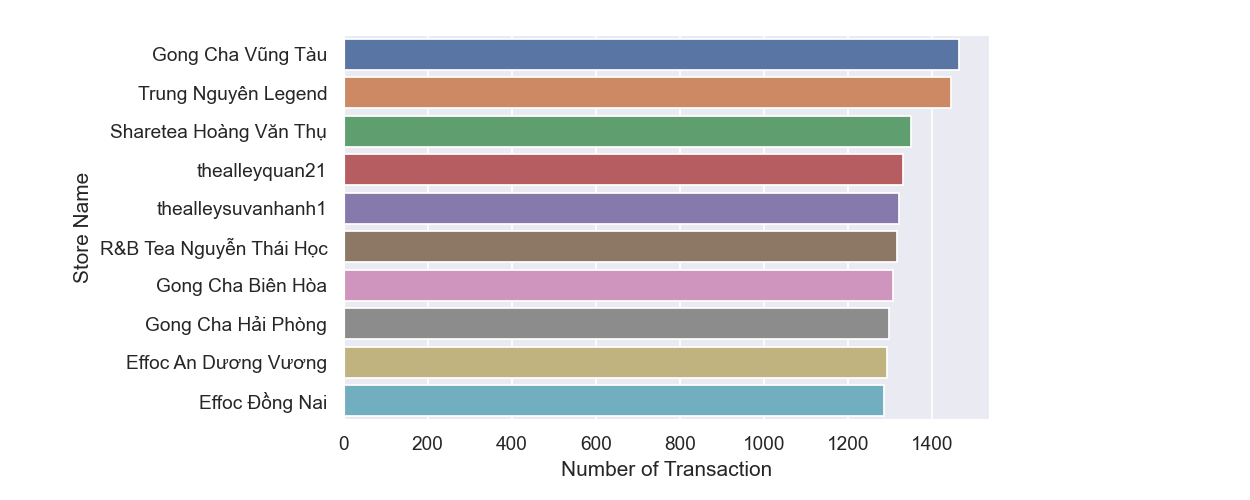

In [44]:
plotdata = transaction_beverage.groupby(["store_name"]).count().sort_values(by="amount",ascending = False)[0:10]
ax = sns.barplot(y=plotdata.index,x="service_id",data = plotdata)
ax.set(xlabel='Number of Transaction', ylabel='Store Name')
box = ax.get_position()
pos2 = [box.x0 + 0.15, box.y0 + 0.05, box.width / 1.5, box.height] 
ax.set_position(pos2)

Ta có thấy được rằng Gong-Cha rất được ưa chuộng và được giao dịch trực tuyến nhiều nhất, trong đó, có 3 chi nhánh Gong Cha đạt top 10, và tổng số giao dịch gần đến 16000. Theo sau là Trung Nguyên, Share Tea, The Alley, R&B. Còn The Coffee House có rất nhiều chi nhánh, tuy nhiên lại rất ít giao dịch diễn ra.

## Câu hỏi 2: Khách hàng thường đến cửa hàng mua nguyên nhân do các cửa hàng đó tập trung ở trung tâm thành phố không?

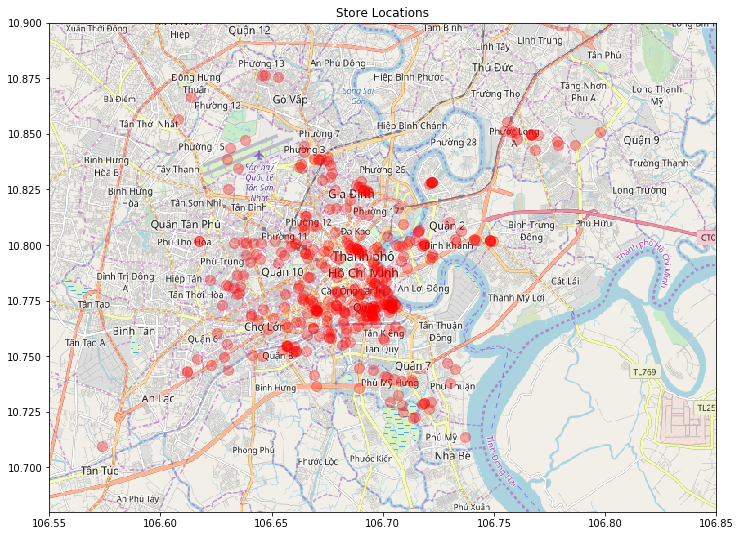

In [ ]:
def plot_on_map(df, location, mapvn, s=10, alpha=0.2):
    fig,ax = plt.subplots(figsize = (14,9))
    ax.scatter(df.store_longitude, df.store_latitude, zorder=1, alpha=alpha, c='r', s=s)
    ax.set_xlim((location[0], location[1]))
    ax.set_ylim((location[2], location[3]))
    ax.set_title('Store Locations')
    ax.imshow(mapvn, zorder=0, extent=location)

location = (106.55, 106.85, 10.68, 10.9)
mapvn = plt.imread("tphcm.png")
plot_on_map(South_data, location, mapvn, s=100, alpha=0.3)

Nhìn vào bản đồ, ta thấy rằng các cửa hàng tập trung chủ yếu ở trung tâm TPHCM và thưa thớt dần khi ra khỏi trung tâm, chứng tỏ rằng vị trí đặt cửa hàng cũng rất quan trọng đến việc thu hút khách hàng và thường đặt ngay những vị trí đắc địa

## Câu hỏi 3: Khách hàng thường đến cửa hàng do thói quen theo thời gian hay không?

Để trả lời được, ta sẽ xem xét trên 3 phương diện: ngày, ngày trong tuần, giờ

In [45]:
transaction_beverage.timestamp = pd.to_datetime(transaction_beverage.timestamp)
hour_count = dict(transaction_beverage.timestamp.dt.hour.value_counts())
day_count = dict(transaction_beverage.timestamp.dt.day.value_counts())
day_of_week_count = dict(transaction_beverage.timestamp.dt.weekday.value_counts())

In [46]:
hour_count = dict(sorted(hour_count.items(), key=lambda x: x))
day_count = dict(sorted(day_count.items(), key=lambda x: x))
day_of_week_count = dict(sorted(day_of_week_count.items(), key=lambda x: x))

<IPython.core.display.Javascript object>


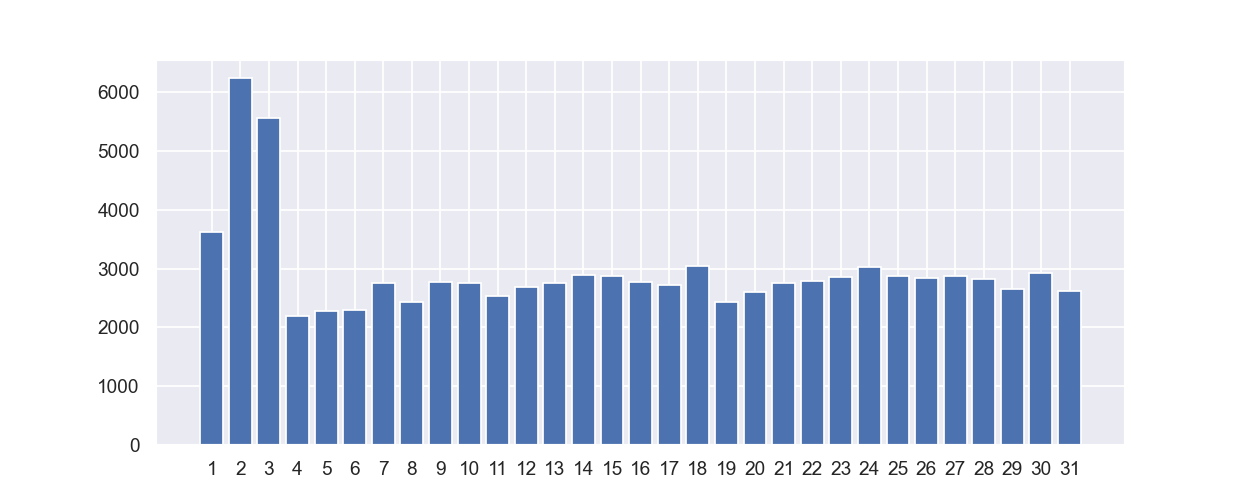

In [47]:
fig, ax = plt.subplots(figsize = (10,4))
ax.bar(day_count.keys(), day_count.values())
ax.set_xticks(range(1,32))
ax.set_xticklabels(range(1,32))
plt.show()

<IPython.core.display.Javascript object>


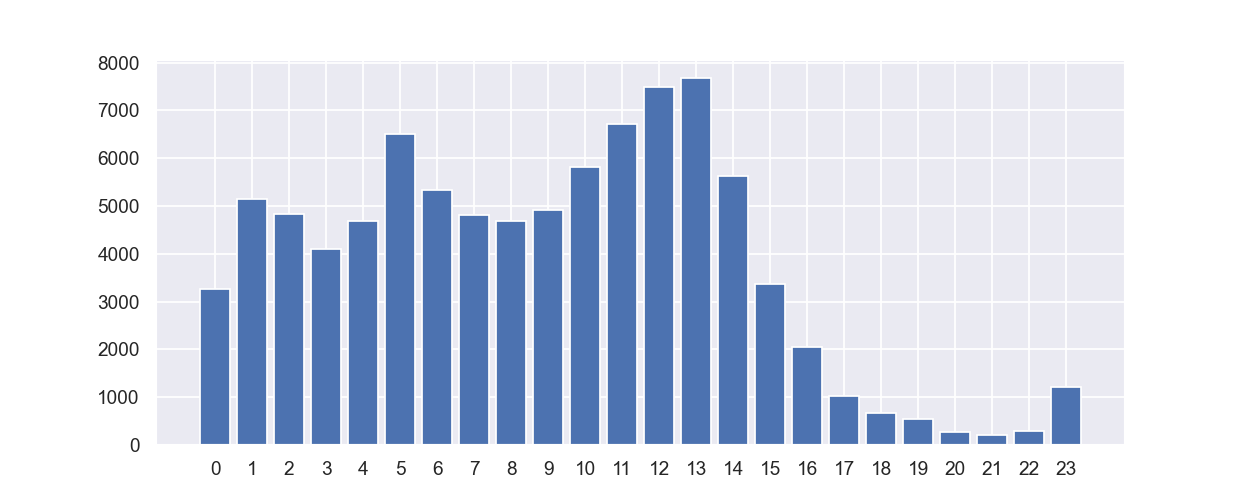

In [48]:
fig, ax = plt.subplots(figsize = (10,4))
ax.bar(hour_count.keys(), hour_count.values())
ax.set_xticks(range(0,24))
ax.set_xticklabels(range(0,24))
plt.show()

<IPython.core.display.Javascript object>


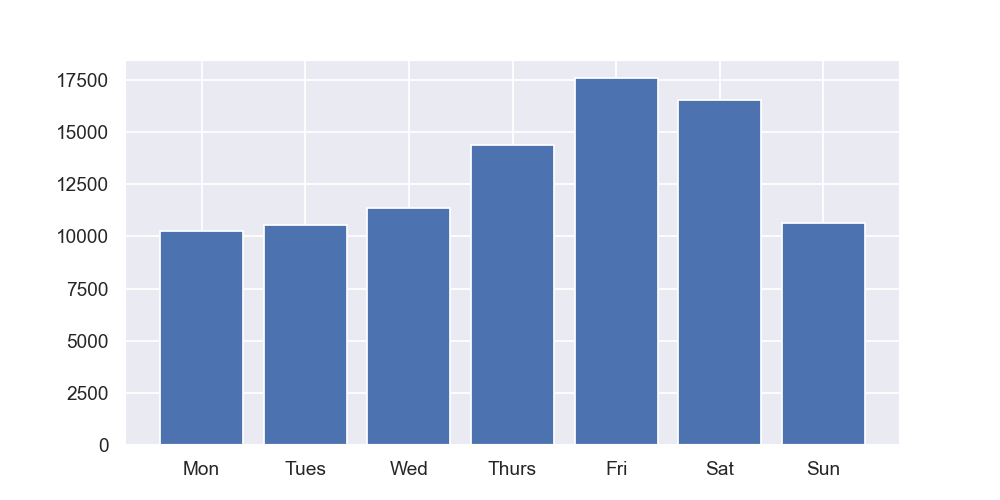

In [49]:
fig, ax = plt.subplots(figsize = (8,4))
ax.bar(day_of_week_count.keys(), day_of_week_count.values())
ax.set_xticks(range(0,7))
ax.set_xticklabels(["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"])
plt.show()

Tại đây, ta có thể thấy rằng, khách hàng thường giao dịch nhiều nhất vào thời gian buổi sáng sớm (5-6h) và vào buổi trưa (11-13h). Khách hàng thường đến vào những ngày gần cuối tuần là thứ 6 và thứ 7

Do đó, khách hàng, theo giả thuyết, thường có thói quen trước khi đi làm (học) sẽ mua nước và trong thời gian nghỉ trưa. Tất nhiên là vào những ngày cuối tuần có thể sẽ tụ họp vui chơi hoặc để bàn bạc công việc

## Câu hỏi 4: Top 10 loại cửa hàng có doanh số bán hàng cao nhất?

Khách hàng thường đến nhiều nhất vào những ngày đầu trong tháng và vào những buổi trưa hàng ngày

<IPython.core.display.Javascript object>


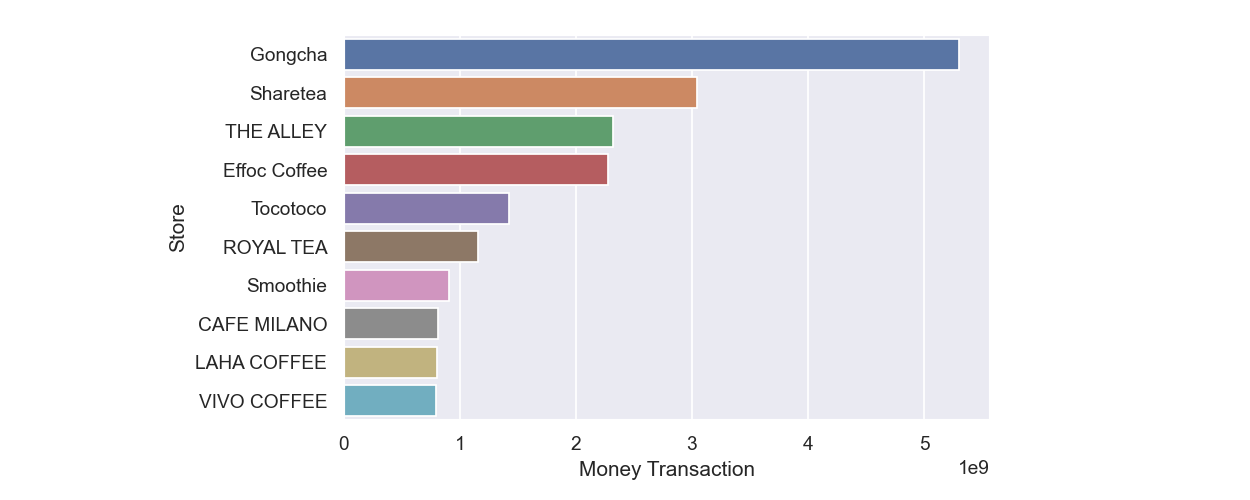

In [52]:
plotdata = transaction_beverage.groupby("Group_store").sum().sort_values(by="amount",ascending = False)[0:10]
ax = sns.barplot(y=plotdata.index, x="amount",data = plotdata)
ax.set(xlabel='Money Transaction', ylabel='Store')
box = ax.get_position()
pos2 = [box.x0 + 0.15, box.y0 + 0.05, box.width / 1.5, box.height] 
ax.set_position(pos2)
top_10_store = plotdata.index.values

Qua biểu đồ này, ta có thể thấy rằng Gongcha được giao dịch trực tuyến nhiều nhất, có doanh số bán hàng lên đến 5 tỉ, tiếp theo đó là sharetea, the alley và effoc coffee

# Kết luận

+ The Coffee House, Gongcha, Tocotoco, Phúc Long đều nổi tiếng do có nhiều chi nhánh tại Việt Nam và cũng đạt số lượng giao dịch nằm trong top 10 cửa hàng. Do đó, khách hàng đến cửa hàng mua sản phẩm 1 phần do độ nổi tiếng của cửa hàng đó
+ Các cửa hàng nổi tiếng nêu trên đều được đặt tại trung tâm thành phố, mục đích chính để dễ dàng tiếp cận người dùng hơn. Chính vì điều đó nên địa điểm cũng 1 phần ảnh hưởng đến số lượng giao dịch của 1 cửa hàng
+ Khách hàng đa phần đến vào buổi sáng sớm (5-6h) và buổi trưa (11-13h) là khoảng thời gian cao điểm do đó là thời điểm chuẩn bị đi làm hoặc giải lao của người mua. Do đó, có thể nói rằng khách hàng đa số mua hàng theo thói quen thời gian
+ Và cuối cùng, nhìn vào số tiền giao dịch mua hàng, ta có thể thấy trong 1 tháng, ngành beverage thu về lợi nhuận rất cao, có thể kể đến như Gongcha, the alley, share tea.

# Nhìn lại quá trình làm đồ án

### Đã gặp những khó khăn gì?

Khó khăn lớn nhất trong đồ án vê việc tiền xử lý, do dữ liệu khá xấu và xuất hiện nhiều outliers hơn dự kiến nên xử lý khó khăn, mất đến hơn 1 tuần để giải quyết hết số dữ liệu đó. Ngoài ra, dữ liệu hơn 1 triệu dòng nên chú ý trong việc code bằng numpy và pandas, tránh sử dụng vòng for nên chưa làm quen kịp thời

### Có học được gì hữu ích?

+ Đặt ra mục tiêu cần giải quyết, đi theo 1 hướng cụ thể, không lan man
+ Tiền xử lý dữ liệu
+ Hiểu về insight data
+ Tình hình doanh thu tổng quan của các cửa hàng

### Nếu có thêm thời gian thì sẽ làm gì?

Nếu có thời gian, em sẽ tiếp tục xây dựng model Machine Learning cho bài toán để gợi ý khách hàng những cửa hàng và nước uống cho họ. Và tất nhiên để làm được, em cần phải crawl dữ liệu về menu của mỗi cửa hàng và cũng như informatic data của khách hàng. Có thể dựa vào tiêu chí số tiền khách hàng đã bỏ ra, rating đồ uống, cửa hàng làm trọng số để thực hiện (model có thể sử dụng: Matrix Factorization, Graph Learning Recommendation)